In [1]:
import msprime, tskit, time
import numpy as np
from IPython.display import SVG
import matplotlib.pyplot as plt

### The Truth
The following will be our final images, and data collection for how the `extend_edges` method compares to other methods/packages including `tsinfer` and `keep_unary`.

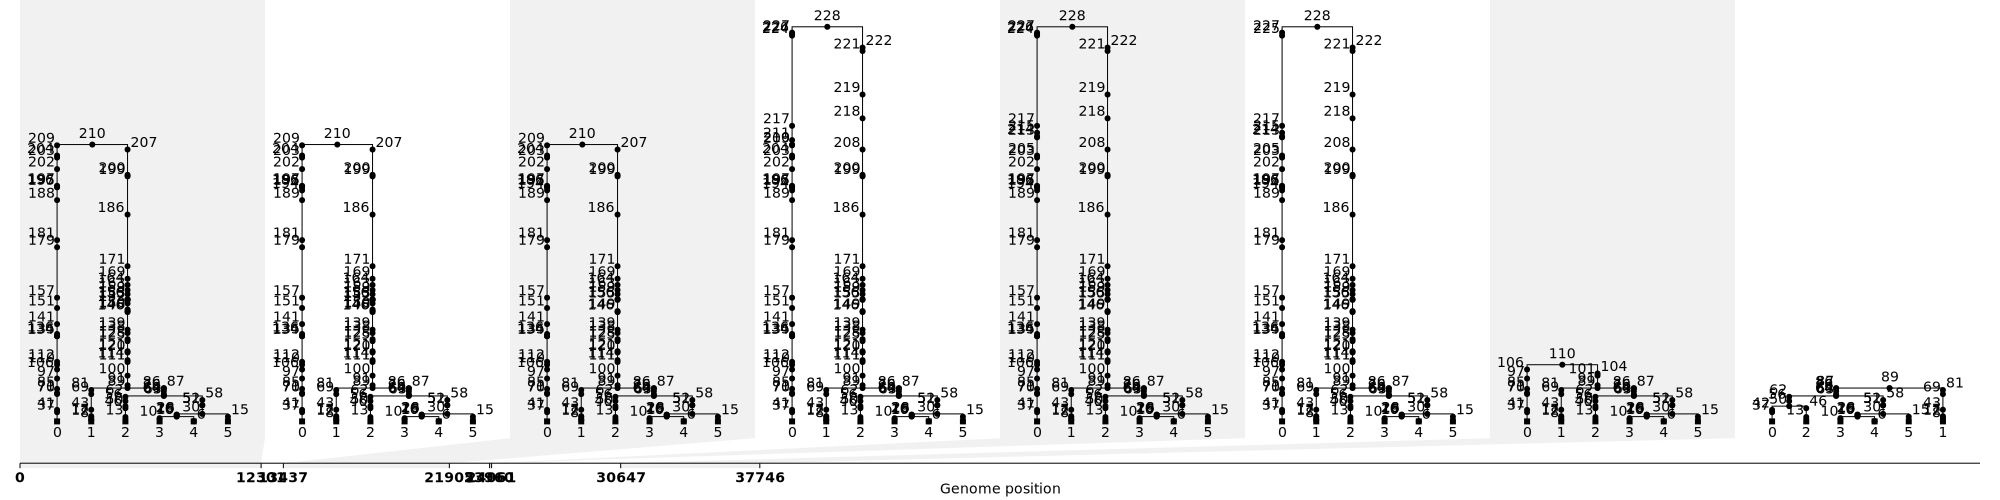

In [2]:
ts = msprime.sim_ancestry(3, population_size=1000, sequence_length=1e6, recombination_rate=1e-8,
                         record_full_arg=True)
SVG(ts.draw_svg(size=(2000, 500), x_lim=[0, 1e5]))

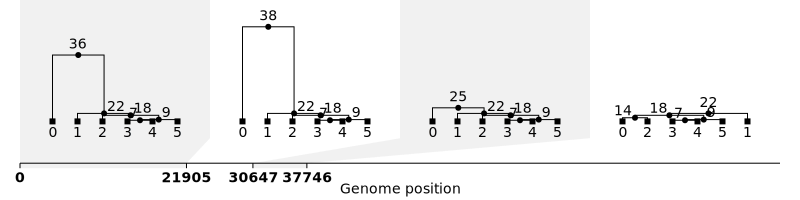

In [3]:
sts = ts.simplify()
SVG(sts.draw_svg(x_lim=[0, 1e5]))

In [5]:
type(sts)

tskit.trees.TreeSequence

In [4]:
ets, n = sts.extend_edges()
print(n)
SVG(ets.draw_svg(x_lim=[0, 1e4]))

forwards: True
All Edges Out []
All Edges In [[2, False], [3, False], [7, False], [8, False], [30, False], [35, False], [47, False], [52, False], [113, False], [114, False]]
------------- 0 0 10
All Edges Out [[114, False], [113, False]]
All Edges In [[119, False], [120, False]]
------------- 21905.0 2 2
All Edges Out [[120, False], [119, False]]
All Edges In [[64, False], [67, False]]
------------- 30647.0 2 2
All Edges Out [[67, False], [64, False], [30, False]]
All Edges In [[17, False], [18, False], [36, False]]
------------- 37746.0 3 3
All Edges Out [[36, False], [18, False], [17, False]]
All Edges In [[25, False], [26, False], [39, False]]
------------- 145630.0 3 3
All Edges Out [[47, False], [8, False], [3, False], [2, False]]
All Edges In [[6, False], [11, False], [12, False], [51, False]]
------------- 199057.0 4 4
EXTEND
All Edges Out [[8, False], [2, False], [35, False], [7, False], [6, False]]
All Edges In [[6, False], [19, False], [21, False], [37, False]]
------------- 

TypeError: cannot unpack non-iterable TreeSequence object